## Piecewise Exponential models and creating custom models

This section will be easier if we recall our three mathematical "creatures" and the relationships between them. First is the survival function, $S(t)$, that represents the probability of living past some time, $t$. Next is the _always non-negative and non-dereasing_ cumulative hazard function, $H(t)$. Its relation to $S(t)$ is:

$$ S(t) = \exp\left(-H(t)\right)$$

Finally, the hazard function, $h(t)$, is the derivative of the cumulative hazard: 

$$h(t) = \frac{dH(t)}{dt}$$

which has the immediate relation to the survival function:

$$S(t) = \exp\left(-\int_{0}^t h(s) ds\right)$$

Notice that any of the three absolutely defines the other two. Some situations make it easier to define one vs the others. For example, in the Cox model, it's easist to work with the hazard, $h(t)$. In this section on parametric univariate models, it'll be easiest to work with the cumulative hazard. This is because of an asymmetry in math: derivatives are much easier to compute that integrals. So, if we define the cumulative hazard, both the hazard and survival function are much easier to reason about vs if we define the hazard and ask questions about the other two. At first, it may be easier to think about the hazard, and that's fine, but so long as we are clever enough to also determine the cumulative hazard, then we can ride the computational train. This will be clear by the end of the tutorial. 

First, let's revisit some simplier parametric models. 

### The Exponential model

Recall that the Exponential model has a constant hazard, that is:

$$ h(t) = \lambda $$

which implies that the cumulative hazard, $H(t)$, has a pretty simple form: $H(t) = \lambda t$. Below we fit this model to some survival data. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from lifelines.datasets import load_waltons
waltons = load_waltons()
T, E = waltons['T'], waltons['E']

<lifelines.ExponentialFitter: fitted with 163 observations, 7 censored>
number of subjects = 163
  number of events = 156
    log-likelihood = -771.913
        hypothesis = lambda_ != 1

---
         coef  se(coef)  lower 0.95  upper 0.95       p  -log2(p)
lambda_ 0.019     0.002       0.016       0.022 <0.0005       inf


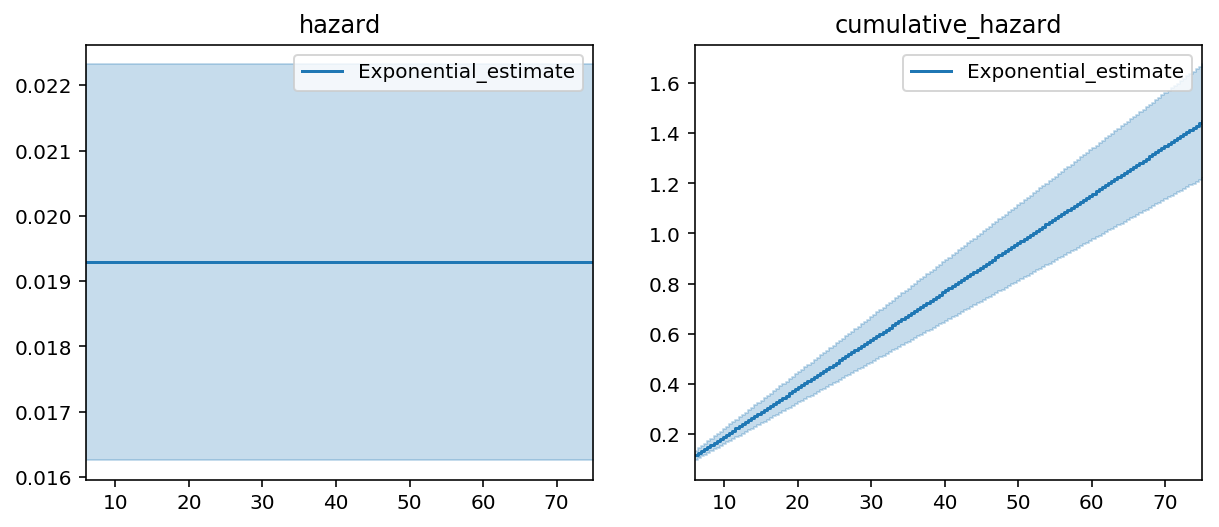

In [2]:
from lifelines import ExponentialFitter

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

epf = ExponentialFitter().fit(T, E)
epf.plot_hazard(ax=ax[0])
epf.plot_cumulative_hazard(ax=ax[1])

ax[0].set_title("hazard"); ax[1].set_title("cumulative_hazard")

epf.print_summary(3)

This model does a poor job of fitting to our data. If I fit a _non-parametric_ model, like the Nelson-Aalen model, to this data, the lack of fit is very obvious. 

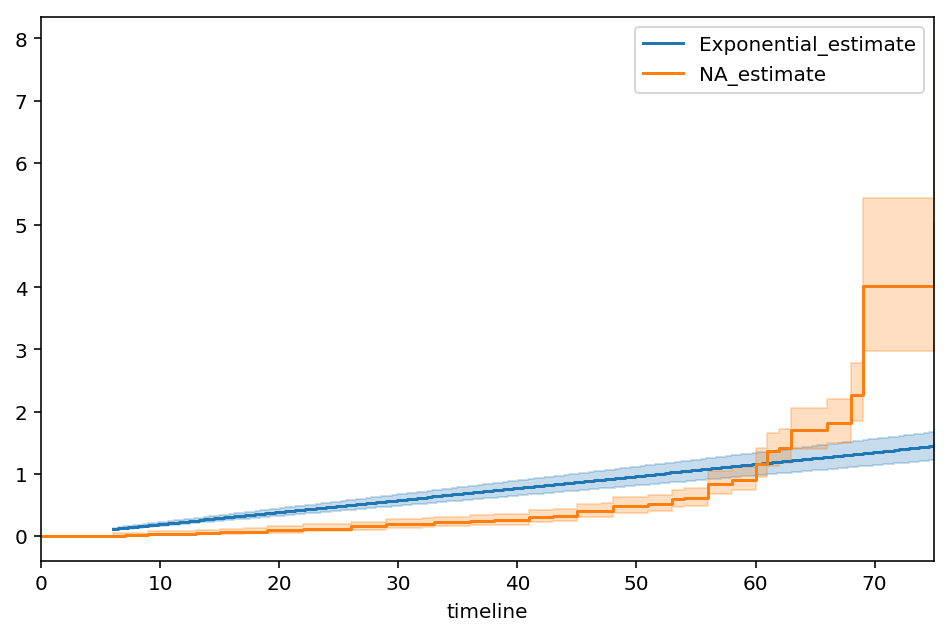

In [3]:
from lifelines import NelsonAalenFitter

ax = epf.plot(figsize=(8,5))

naf = NelsonAalenFitter().fit(T, E)
ax = naf.plot(ax=ax)
plt.legend()

It should be clear that the single parameter model is just averaging the hazards over the entire time period. In reality though, the true hazard rate exhibits some complex non-linear behaviour.

### Piecewise Exponential models

What if we could break out model into different time periods, and fit an exponential model to each of those? For example, we define the hazard as:

$$ 
h(t) = \begin{cases}
        \lambda_0,  & \text{if $t \le \tau_0$} \\
        \lambda_1 & \text{if $\tau_0 < t \le \tau_1$} \\
        \lambda_2 & \text{if $\tau_1 < t \le \tau_2$} \\
        ... 
      \end{cases}
$$

This model should be flexible enough to fit better to our dataset. 

The cumulative hazard is only slightly more complicated, but not too much and can still be defined in Python. In _lifelines_, univariate models are constructed such that one _only_ needs to define the cumulative hazard model with the parameters of interest, and all the hard work of fitting, creating confidence intervals, plotting, etc. is taken care. 

For example, _lifelines_ has implemented the `PiecewiseExponentialFitter` model. Internally, the code is a single function that defines the cumulative hazard. The user specifies where they believe the "breaks" are, and _lifelines_ estimates the best $\lambda_i$. 


<lifelines.PiecewiseExponentialFitter: fitted with 163 observations, 7 censored>
number of subjects = 163
  number of events = 156
    log-likelihood = -3.970
        hypothesis = lambda_0_ != 1, lambda_1_ != 1, lambda_2_ != 1

---
           coef  se(coef)  lower 0.95  upper 0.95       p  -log2(p)
lambda_0_ 0.006     0.001       0.004       0.008 <0.0005       inf
lambda_1_ 0.032     0.004       0.024       0.040 <0.0005       inf
lambda_2_ 0.213     0.028       0.158       0.269 <0.0005   556.834


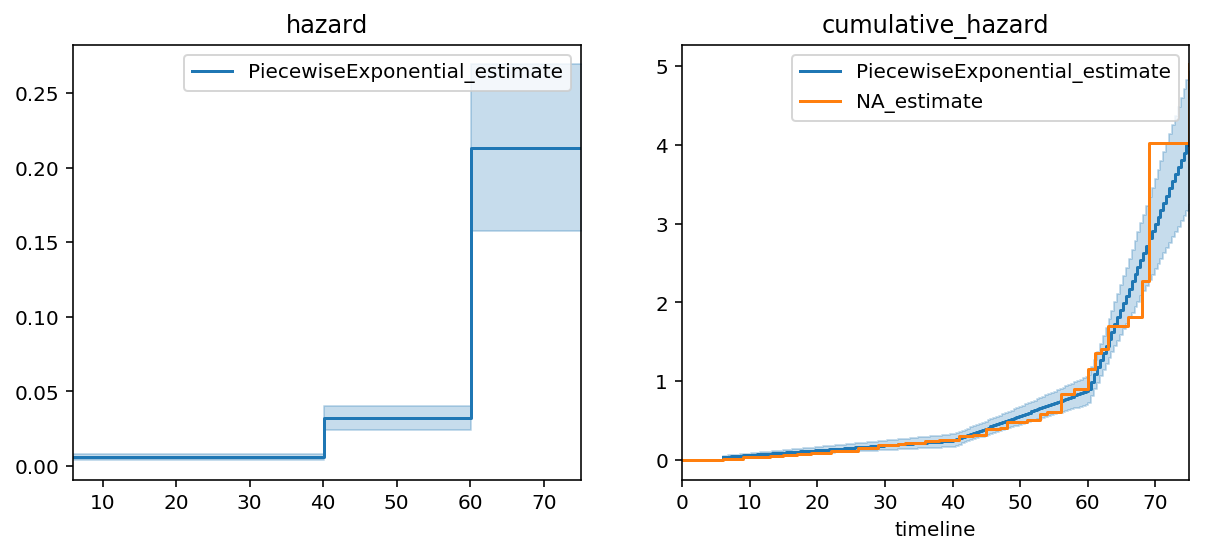

In [4]:
from lifelines import PiecewiseExponentialFitter

# looking at the above plot, I think there may be breaks at t=40 and t=60. 
pf = PiecewiseExponentialFitter(breakpoints=[40, 60]).fit(T, E)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax = pf.plot(ax=axs[1])
pf.plot_hazard(ax=axs[0])

ax = naf.plot(ax=ax, ci_show=False)
axs[0].set_title("hazard"); axs[1].set_title("cumulative_hazard")

pf.print_summary(3)


We can see a much better fit in this model. A quantitative measure of better fit is to compare the log-likelihood  mthe exponential model and the piecewise exponential model (higher is better). The log-likelihood went from -771.913 to -3.970, respectively. We could keep going and add more and more breakpoints, but that would end up overfitting to the data. 

### Univarite models in _lifelines_

I mentioned that the `PiecewiseExponentialFitter` was implemented using only its cumulative hazard function. This is not a lie. _lifelines_ has very general semantics for univariate fitters. For example, this is how the entire `ExponentialFitter` is implemented:

```python
class ExponentialFitter(ParametericUnivariateFitter):

    _fitted_parameter_names = ["lambda_"]

    def _cumulative_hazard(self, params, times):
        lambda_ = params[0]
        return lambda_ * times
```

We only need to specify the cumulative hazard function because of the 1-1 relationship between the cumulative hazard function and the survival function and the hazard rate. From there, _lifelines_ handles the rest. 


### Defining our own survival models


To show off the flexability of _lifelines_ univariate models, we'll create a brand new, never before seen, survival model. Looking at the Nelson-Aalen fit, the cumulative hazard looks looks like their might be an asymptote at $t=80$. This may correspond to an absolute upper limit of subjects' lives. Let's start with that functional form.

$$ H_1(t; \alpha) = \frac{\alpha}{(80 - t)} $$

We subscript $1$ because we'll investigate other models. In a _lifelines_ univariate model, this is defined in the following code. 

**Important**: in order to compute derivatives, you must use the numpy imported from the `autograd` library. This is a thin wrapper around the original numpy. See `import` below. 

In [5]:
from lifelines.fitters import ParametericUnivariateFitter

import autograd.numpy as np

class InverseTimeHazardFitter(ParametericUnivariateFitter):
    
    # we tell the model what we want the names of the unknown parameters to be
    _fitted_parameter_names = ['alpha_']

    # this is the only function we need to define. It always takes two arguments:
    #   params: an iterable that unpacks the parameters you'll need in the order of _fitted_parameter_names
    #   times: avector of times that will be passed in.
    def _cumulative_hazard(self, params, times):
        alpha = params[0]
        return alpha /(80 - times)

<lifelines.InverseTimeHazardFitter: fitted with 163 observations, 7 censored>
number of subjects = 163
  number of events = 156
    log-likelihood = -4.281
        hypothesis = alpha_ != 1

---
        coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
alpha_ 21.51      1.72       18.13       24.88 <0.005    106.22


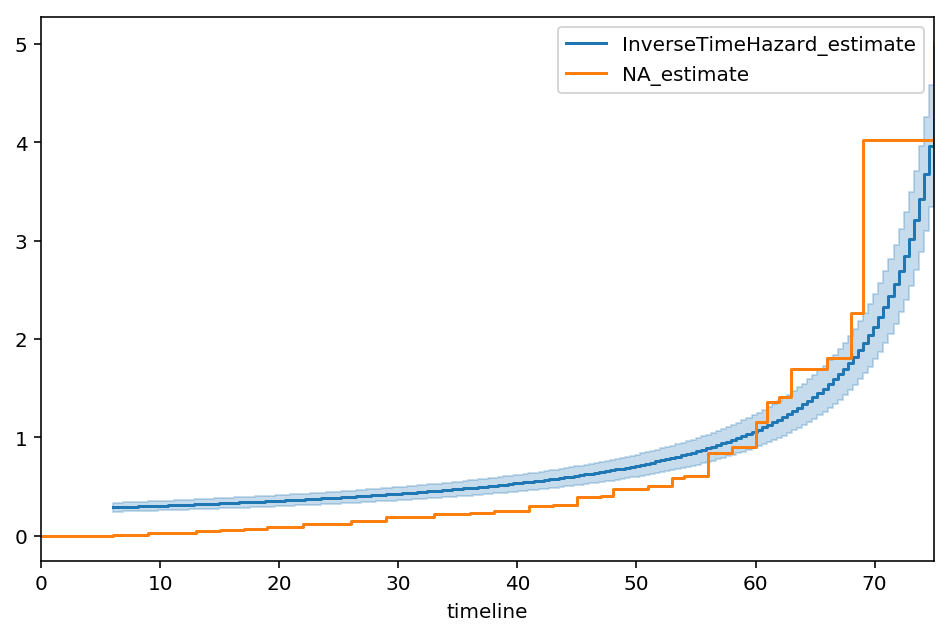

In [6]:
itf = InverseTimeHazardFitter()
itf.fit(T, E)
itf.print_summary()

ax = itf.plot(figsize=(8,5))
ax = naf.plot(ax=ax, ci_show=False)
plt.legend()

The best fit of the model to the data is:

$$H_1(t) = \frac{21.51}{80-t}$$

Our choice of 80 as an asymptote was maybe mistaken, so let's allow the asymptote to be another parameter:

$$ H_2(t; \alpha, \beta) = \frac{\alpha}{\beta-t} $$

If we define the model this way, we need to add a bound to the values that $\beta$ can take. Obviously it can't be smaller than or equal to the maximum observed duration. Generally, the cumulative hazard _must be positive and non-decreasing_. Otherwise the model fit will hit convergence problems. 

In [7]:
class TwoParamInverseTimeHazardFitter(ParametericUnivariateFitter):
    
    _fitted_parameter_names = ['alpha_', 'beta_']
    
    # Sequence of (min, max) pairs for each element in x. None is used to specify no bound
    _bounds = [(0, None), (75.0001, None)]
    
    def _cumulative_hazard(self, params, times):
        a, b = params
        return a / (b - times)

<lifelines.TwoParamInverseTimeHazardFitter: fitted with 163 observations, 7 censored>
number of subjects = 163
  number of events = 156
    log-likelihood = -4.206
        hypothesis = alpha_ != 1, beta_ != 76

---
        coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
alpha_ 16.50      1.51       13.55       19.46 <0.005     79.98
beta_  76.55      0.38       75.80       77.30   0.15      2.73


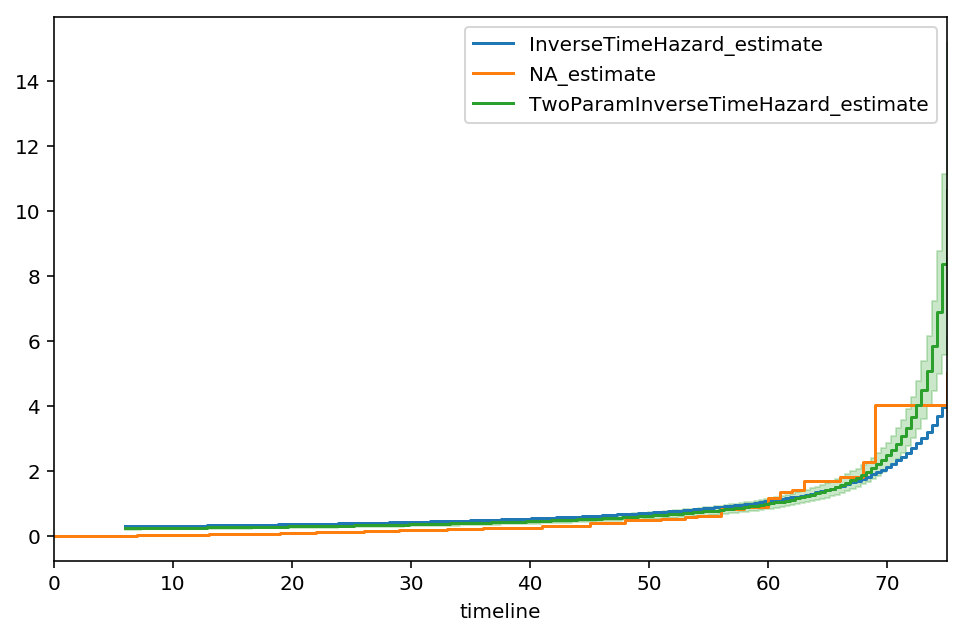

In [8]:
two_f = TwoParamInverseTimeHazardFitter()
two_f.fit(T, E)
two_f.print_summary()

ax = itf.plot(ci_show=False, figsize=(8,5))
ax = naf.plot(ax=ax, ci_show=False)
two_f.plot(ax=ax)
plt.legend()

From the output, we see that the value of 76.55 is the suggested asymptote, that is:

$$H_2(t) = \frac{16.50} {76.55  - t}$$

The curve also appears to track against the Nelson-Aalen model better too. Let's try one additional parameter, $\gamma$, some sort of measure of decay. 

$$H_3(t; \alpha, \beta, \gamma) = \frac{\alpha}{(\beta-t)^\gamma} $$


In [9]:
from lifelines.fitters import ParametericUnivariateFitter

class ThreeParamInverseTimeHazardFitter(ParametericUnivariateFitter):
    
    _fitted_parameter_names = ['alpha_', 'beta_', 'gamma_']
    _bounds = [(0, None), (75.0001, None), (0, None)]
    
    # this is the only function we need to define. It always takes two arguments:
    #   params: an iterable that unpacks the parameters you'll need in the order of _fitted_parameter_names
    #   times: a numpy vector of times that will be passed in by the optimizer
    def _cumulative_hazard(self, params, times):
        a, b, c = params
        return a / (b - times) ** c

<lifelines.ThreeParamInverseTimeHazardFitter: fitted with 163 observations, 7 censored>
number of subjects = 163
  number of events = 156
    log-likelihood = -3.984
        hypothesis = alpha_ != 1, beta_ != 76, gamma_ != 1

---
             coef   se(coef)  lower 0.95  upper 0.95      p  -log2(p)
alpha_ 1588776.28 3775137.44 -5810357.13  8987909.70   0.67      0.57
beta_      100.88       5.88       89.35      112.41 <0.005     15.38
gamma_       3.83       0.50        2.85        4.81 <0.005     25.82


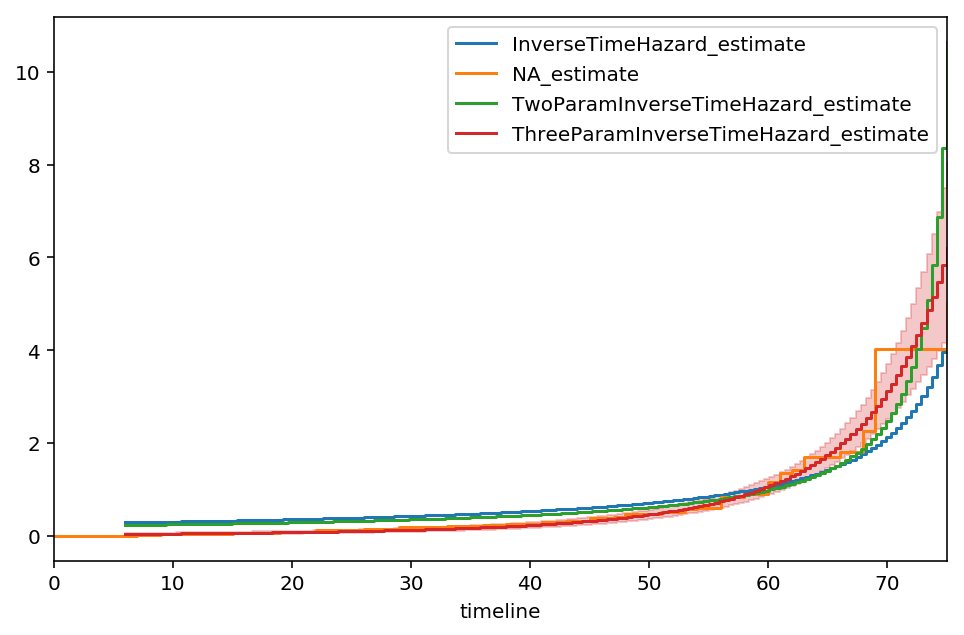

In [10]:
three_f = ThreeParamInverseTimeHazardFitter()
three_f.fit(T, E)
three_f.print_summary()

ax = itf.plot(ci_show=False, figsize=(8,5))
ax = naf.plot(ax=ax, ci_show=False)
ax = two_f.plot(ax=ax, ci_show=False)
ax = three_f.plot(ax=ax)
plt.legend()

Our new asymptote is at $t\approx 100, \text{c.i.}=(87, 112)$. The model appears to fit the early times better than the previous models as well, however our $\alpha$ parameter has more uncertainty now. Continuing to add parameters isn't advisable, as we will overfit to the data. 

### Why fit parametric models anyways?

Taking a step back, we are fitting parameteric models and comparing them to the non-parametric Nelson-Aalen. Why not just always use the Nelson-Aalen model? 

1) Sometimes we have scientific motivations to use a parametric model. That is, using domain knowledge, we may know the system has a parametric model and we wish to fit to that model. 

2) In a parametric model, we are borrowing information from _all_ observations to determine the best parameters. To make this more clear, imagine take a single observation and changing it's value wildly. The fitted parameters would change as well. On the other hand, imagine doing the same for a non-parametric model. In this case, only the local survival function or hazard function would change. Because parametric models can borrow information from all observations, and there are much _fewer_ unknowns than a non-parametric model, parametric models are said to be more _statistical efficient._ 

3) Extrapolation: non-parametric models are not easily extended to values outside the observed data. On the other hand, parametric models have no problem with this. However, extrapolation outside observed values is a very dangerous activity. 

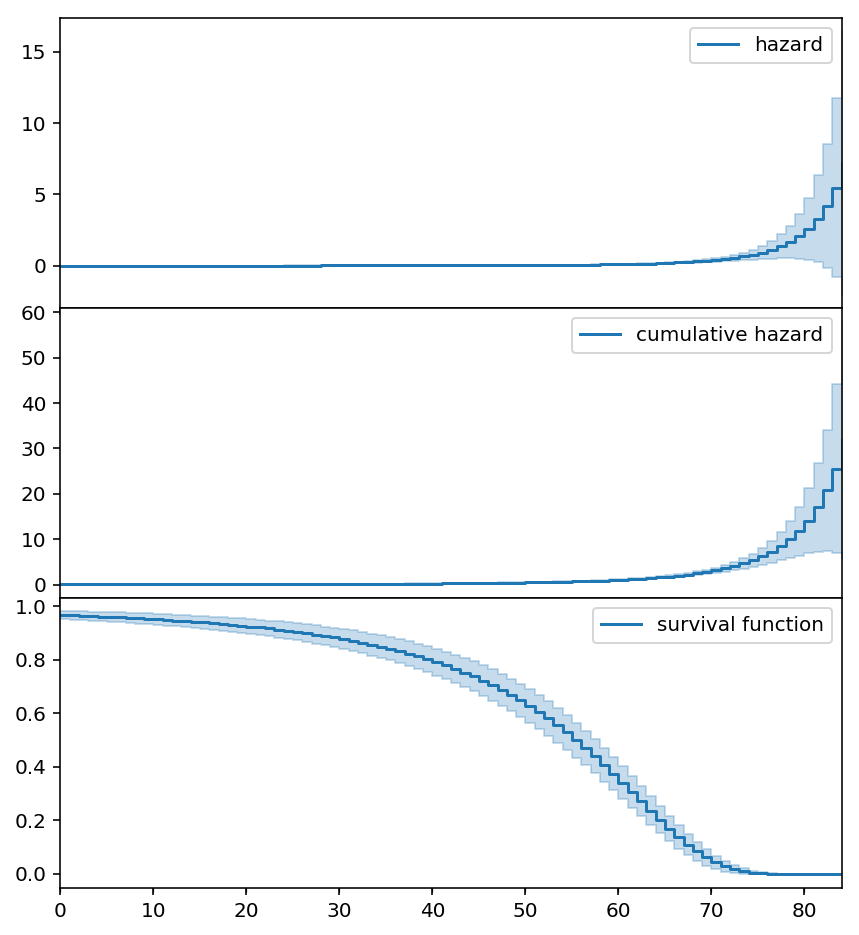

In [11]:
fig, axs = plt.subplots(3, figsize=(7, 8), sharex=True)


new_timeline = np.arange(0, 85)

three_f = ThreeParamInverseTimeHazardFitter().fit(T, E, timeline=new_timeline)


three_f.plot_hazard(label='hazard', ax=axs[0]).legend()
three_f.plot_cumulative_hazard(label='cumulative hazard',  ax=axs[1]).legend()
three_f.plot_survival_function(label='survival function',  ax=axs[2]).legend()

fig.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()


### Looking for more examples of what you can build?

See other unique survival models in the docs on [time-lagged survival](Modelling time-lagged conversion rates.ipynb)